In [41]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re, sys

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
# sys.path.insert(1, '/path/to/application/app/folder')
from utility import *
# import gaussian_kde

# import warnings
# warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline



Toggle code

In [42]:
dataset_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\"
output_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\output\\"

In [43]:
df_corrs_ni_nm = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df_corrs_ni_nm.zip",compression='zip')
df = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df.zip",compression='zip')
df_merged = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df_merged.zip",compression='zip')

In [44]:
pvds_elections = pd.read_stata(dataset_folder + "pvds_elections.dta")
# pvds_elections

# selfrile_pol not in handbook ... but appears to be just "max-min"

pvds_parties = pd.read_stata(dataset_folder + "pvds_parties.dta", columns = ['country', 'edate', 'marpor_year', 'rile', 'selfrile_min',
       'selfrile_max', 'selfrile_med', 'selfrile_pol', 'N_voter'])

pvds_parties["party"] = pd.read_stata(dataset_folder + "pvds_parties.dta",
                                      convert_categoricals=False, columns = ['party'])["party"]
                             
pvds_parties = pvds_parties[['country', 'edate', 'marpor_year', 'party', 'rile', 'selfrile_min',
       'selfrile_max', 'selfrile_med', 'selfrile_pol', 'N_voter']]
# pvds_parties

# non-unique category
# cze: kds christian democratic party

pvds_mikro = pd.read_stata(dataset_folder + "pvds_mikro.dta",
                           columns=['country', 'edate', 'marpor_year', 'rile', 'dataset_id',
       'survey_country', 'survey_year', 'fieldwork_in', 'fieldwork_out',
       'fieldwork_diff', 'current_vote_type', 'selfrile_survey_type',
       'selfrile', 'observation_origin', 'missing_type',
       'survey_partypref_missing', 'party_na', 'selfrile_na', 'A1005', 'B1005',
       'C1005', 's007', 'id'])

pvds_mikro['party'] = pd.read_stata(dataset_folder + "pvds_mikro.dta",
                                      convert_categoricals=False, columns = ['party'])["party"]
pvds_mikro = pvds_mikro[['country', 'edate', 'marpor_year', 'party', 'rile', 'dataset_id',
       'survey_country', 'survey_year', 'fieldwork_in', 'fieldwork_out',
       'fieldwork_diff', 'current_vote_type', 'selfrile_survey_type',
       'selfrile', 'observation_origin', 'missing_type',
       'survey_partypref_missing', 'party_na', 'selfrile_na', 'A1005', 'B1005',
       'C1005', 's007', 'id']]
# pvds_mikro

In [45]:
pvds_mikro.describe(include='all')[pvds_mikro.columns[20:]]

# rile: party rile from CMP
# datasety_id: [11,12,13,21,31]
# survey_country: Woah - mixes country numbers (CMP??) and ISO-3 char strings!
# survey_year: 1970-2009 (all years, coverage not perfectly even, but not very far off)
# fieldwork_in, fieldwork_out: fieldwork dates
# fieldwork_diff: days relative to the marpor anchored election
# current_vote_type: most common two categories "lastvote" and "voteint" are obvious, rest are pretty opaque
#     survey variables we used to capture the respondents’ expressed party preference with regard to the current, next or last election, respectively
# selfrile_survey_type: ['lrs', 'e033', 'B3045', 'C3013', 'A3031'] - opaque references specific to source!
# selfrile: 1-9 (recoded from differing scales!), includes all DK/won't answer/wasn't asked ... options
# observation_origin: ['survey', 'cmp+survey']
#     a general overview from which data set the information for an observation is taken
# missing_type: ['mapping variable is missing value (.)',
#                'MATCH! cmp and survey entry successfully mapped',
#                'cmp party missing']
#     when a respondent did not name a party to which he could be matched or if this
#     party is not included in the Manifesto Data Collection
# survey_partypref_missing: lots of categories - all 
#     unifies the missing codes for repondents’ party vote choice as reported in
#     the surveys
#     whether or not in the surveys linked to the election data the
#     questions about party preference in different vote choice questions and/or selfplacement of the respondents on the left-right scales were posed at all
#     (party_na and selfrile_na).
# party_na, selfrile_na both dummies
    # To allow users to distinguish between respondents from the survey data
    # sets as objects of the analysis with several possible observations for expressed vote
    # choices in the Party-Voter Data Set we included the unique identifier variables for
    # survey respondents from the original data sources (A1005, B1005, C1005, id, s007).
# B1005,C1005,s007,id: id variables


,B1005,C1005,s007,id
count,1707994,1707994,335814.0,9.761760e+05
unique,43211,33138,109926.0,NaN
top,,,294720.0,NaN
freq,1541827,1574403,6.0,NaN
first,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,4.849953e+05
std,NaN,NaN,NaN,3.149291e+05
min,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,2.071738e+05


In [46]:
pvds_mikro["selfrile_na"].value_counts()
#.value_counts().sort_index()

0.0    1630110
1.0      77884
Name: selfrile_na, dtype: int64

In [47]:
# already there as marpor_year

# cmp_party_voter["year"] = cmp_party_voter["edate"].dt.year
# cmp_party_voter["year"].value_counts()

In [48]:
# cmp_party_voter.describe()

In [49]:
# cmp_party_voter["party_na"].value_counts()
# cmp_party_voter["fieldwork_diff"].value_counts()

In [50]:
# just the rows for which we know party pref
# 
pvds_mikro["party"] = pvds_mikro["party"].replace(-99,np.nan)
cmp_party_voter = pvds_mikro[pvds_mikro["party"].notnull()].copy()



non_answers = ["don't know", 'refused to answer', 'question not asked in survey',
                  'missing / no answer', 'no understanding of left-right']

replace_dict = dict(zip(non_answers,[np.nan]*len(non_answers)))

cmp_party_voter['selfrile'] = cmp_party_voter['selfrile'].replace(replace_dict)#.astype(int)

cmp_party_voter = cmp_party_voter[cmp_party_voter['selfrile'].notnull()].copy()

cmp_party_voter['selfrile'] = cmp_party_voter['selfrile'].astype(int)

cmp_party_voter['selfrile'].value_counts()

5    208666
3     68953
6     66359
4     65891
7     59841
9     27178
2     21980
8     21909
1     20566
Name: selfrile, dtype: int64

In [51]:
cmp_party_voter = cmp_party_voter[["survey_year","party","selfrile"]].astype(int)

In [52]:
partyfacts_core_parties = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-core-parties.csv")
partyfacts_external_parties = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-external-parties.csv")
partyfacts_countries = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-countries.csv")
partyfacts_datasets = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-datasets.csv")

pf_country_to_code = partyfacts_countries[["country","name"]].set_index("name")["country"].apply(lambda x: x.lower())

In [53]:
cmp_ids_to_pf = partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="manifesto"].set_index("dataset_party_id")["partyfacts_id"]
cmp_ids_to_pf.index = [int(x) for x in cmp_ids_to_pf.index]


In [54]:
# [x for x in cmp_party_voter["party"].unique() if x not in cmp_ids_to_pf.index]

In [55]:
# cmp_party_voter_parties = pvds_parties.set_index("party")
# cmp_party_voter_parties.index = [int(x) for x in cmp_party_voter_parties.index]

In [56]:
# cmp_party_voter_parties.loc[[21051, 21092, 21031, 53051, 51041, 31061]]

# confusingly, theses do not appear in partyfacts or the cmp codebook - or even their previous versions!

In [57]:
parties_not_in_cmp = [21051, 21092, 21031, 53051, 51041, 31061]

cmp_party_voter = cmp_party_voter[cmp_party_voter["party"].apply(lambda x: x not in parties_not_in_cmp)].copy()

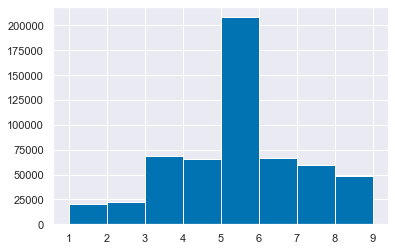

In [58]:
cmp_party_voter["selfrile"].hist(bins=8)

# not a terribly convincing distribution!

In [59]:
cmp_party_voter["selfrile"] = (cmp_party_voter["selfrile"]-1)/8

In [60]:
cmp_party_voter["partyfacts_id"] = cmp_ids_to_pf.loc[cmp_party_voter["party"]].values

In [61]:
cmp_party_voter.drop_duplicates().shape,cmp_party_voter.shape,

((15956, 4), (560663, 4))

In [62]:
cmp_party_voter["partyfacts_id"].apply(lambda x: x in df_merged.index).sum()

560663

In [63]:
cmp_party_voter["selfrile"].describe()

count    560663.000000
mean          0.501832
std           0.224272
min           0.000000
25%           0.375000
50%           0.500000
75%           0.625000
max           1.000000
Name: selfrile, dtype: float64

In [64]:
len( cmp_party_voter["partyfacts_id"].unique() )

# only 387 parties - all in our dataset

cmp_party_voter.groupby("partyfacts_id").apply(lambda x: x==.5).mean()
cmp_party_voter.groupby("partyfacts_id").apply(lambda x: x==1).mean()
cmp_party_voter.groupby("partyfacts_id").apply(lambda x: x==0).mean()

survey_year      0.000000
party            0.000000
selfrile         0.036671
partyfacts_id    0.000000
dtype: float64

In [65]:
selfrile_count = cmp_party_voter.groupby("partyfacts_id").count()["selfrile"]
selfrile_mean = cmp_party_voter.groupby("partyfacts_id").mean()["selfrile"]
selfrile_median = cmp_party_voter.groupby("partyfacts_id").median()["selfrile"]
selfrile_std = cmp_party_voter.groupby("partyfacts_id").std()["selfrile"]
selfrile_skew = cmp_party_voter.groupby("partyfacts_id").skew()["selfrile"]
selfrile_kurtosis = cmp_party_voter.groupby("partyfacts_id").apply(pd.Series.kurt)["selfrile"]

selfrile_centre_frac = cmp_party_voter.groupby("partyfacts_id").apply(lambda x: np.mean(x==.5))["selfrile"]
selfrile_farleft_frac = cmp_party_voter.groupby("partyfacts_id").apply(lambda x: np.mean(x==0.0))["selfrile"]
selfrile_farright_frac = cmp_party_voter.groupby("partyfacts_id").apply(lambda x: np.mean(x==1.0))["selfrile"]


In [66]:
# cmp_party_voter[["selfrile","partyfacts_id"]][cmp_party_voter["survey_year"]==1990]["partyfacts_id"].kurtosis()
selfrile_df = pd.DataFrame([selfrile_count,selfrile_mean,selfrile_median,selfrile_std,selfrile_skew,selfrile_kurtosis,
              selfrile_centre_frac,selfrile_farleft_frac,selfrile_farright_frac]).T
selfrile_df.columns = ["N","mean","median","std","skew","kurtosis","centre_frac","farleft_frac","farright_frac"]
selfrile_df
# cmp_party_voter.groupby("partyfacts_id").apply(lambda x: np.mean(x==.5))#.groupby("partyfacts_id").mean()

,N,mean,median,std,skew,kurtosis,centre_frac,farleft_frac,farright_frac
partyfacts_id,,,,,,,,,
3,32.0,0.460938,0.5000,0.136331,-0.118107,0.685435,0.468750,0.000000,0.000000
4,258.0,0.402132,0.5000,0.235969,0.341010,0.281894,0.360465,0.100775,0.042636
5,206.0,0.568568,0.5000,0.214742,0.222842,0.485314,0.466019,0.019417,0.097087
9,142.0,0.484155,0.5000,0.204590,-0.177308,0.784503,0.478873,0.049296,0.028169
10,622.0,0.339228,0.3750,0.164773,0.296914,0.286261,0.242765,0.040193,0.001608
...,...,...,...,...,...,...,...,...,...
6183,385.0,0.246753,0.2500,0.194293,0.591339,0.268442,0.171429,0.225974,0.005195
6202,108.0,0.559028,0.5000,0.183631,0.109614,1.480872,0.490741,0.018519,0.037037
6241,811.0,0.702990,0.7500,0.179070,0.088236,-0.787588,0.256473,0.000000,0.135635


In [67]:
# selfrile_df["N"].hist(bins=100)

In [79]:
mask = selfrile_df["N"]>100

df_merged.loc[selfrile_df.index[mask]].corrwith(selfrile_df["mean"][mask]).dropna().sort_values().tail(50)


Degrees of freedom <= 0 for slice
divide by zero encountered in true_divide


(parlgov)family__cons                                                   0.452590
(ees14)immigration                                                      0.455615
(ches)intgroup__international democrat union                            0.461442
(ees14)markeco                                                          0.462041
(manifesto)per401                                                       0.480391
(pip)Index Jahn: LR Core Importance                                     0.495767
(manifesto)markeco                                                      0.517295
(pip)Index Budge et al.: Market Economy                                 0.520009
(ees14)multicult                                                        0.525994
(ches)cosmo                                                             0.537059
(ches)membership_sd                                                     0.545444
(ches)epgroup__European People’s Party – European Democrats (EPP-ED)    0.549125
(ees14)rile_mrg             

In [69]:
df_merged.loc[selfrile_df.index].corrwith(selfrile_df["std"]).dropna().sort_values().tail(50)

### looks reasonable!

(ees14)per_v1_4082b                                     0.236039
(ees14)per_v2_5012b                                     0.236317
(manifesto)per601                                       0.239889
(ees14)per_v3_603a                                      0.240041
(parlgov)liberty_authority                              0.240544
(ees14)per_v1_504a                                      0.240845
(ches)urban_salience                                    0.242475
(ches)family__rad right                                 0.244131
(ees14)per_v1_606a                                      0.245673
(manifesto)per6013                                      0.248052
(ches)eu_agri                                           0.255137
(ches)immig                                             0.255606
(ches)civlib                                            0.258578
(ches)enviro                                            0.260245
(ches)eumember__Other                                   0.263987
(manifesto)per1011       

In [70]:
selfrile_farright_frac
# lazy version, use the year-meaned merged dataset -> TOO BIG!

# df_merged.loc[cmp_party_voter["partyfacts_id"]]

partyfacts_id
3       0.000000
4       0.042636
5       0.097087
9       0.028169
10      0.001608
          ...   
6183    0.005195
6202    0.037037
6241    0.135635
6804    0.214286
8268    0.054348
Name: selfrile, Length: 387, dtype: float64

In [71]:
cmp_party_voter["survey_year"].value_counts()

1990    40545
1995    40205
1989    35304
2002    28130
1993    25331
1999    23818
1996    22423
1997    21528
1994    21338
1991    21313
1992    18402
1988    18396
1979    17685
2000    17559
1986    16030
2007    15676
1978    15069
2005    13909
1998    12728
1987    12656
1981    12326
1985    12177
2001    11408
2004    10493
1980     9029
2006     8902
2009     8729
2003     8017
1976     8005
1977     7880
1982     6786
2008     5983
1983     4933
1984     4579
1973     3371
Name: survey_year, dtype: int64

In [72]:
df["year"].value_counts().head(50)

2014    689
1999    440
2016    417
2006    413
2010    405
2002    378
1992    373
1996    368
2009    337
2004    331
2019    328
2011    299
1994    287
2007    280
2015    242
1984    240
2017    227
1990    221
1979    210
1995    204
1988    203
1998    189
2003    180
1987    179
1991    175
2012    173
2008    170
1993    169
1989    165
2000    157
2013    157
2005    149
2001    140
1977    130
1983    126
1981    121
1997    121
1953     95
1968     93
1972     89
1971     85
1975     84
1973     84
1949     80
1958     79
1985     78
1986     76
1948     74
1951     74
1974     72
Name: year, dtype: int64

In [73]:
####
## COVERAGE
## PARTY-YEAR level data, looking at ... parties / COUNTRY X YEAR?

In [74]:
len( df.groupby(["country","year"])["partyfacts_id"].count().reset_index()["country"].unique() )

# only 58 countries!

58

In [75]:
df.groupby(["country","year"])["partyfacts_id"].count().reset_index()["year"].unique()

array([1991, 1992, 1996, 1997, 2001, 2014, 1995, 1999, 2003, 2007, 2012,
       1946, 1949, 1951, 1954, 1955, 1958, 1961, 1963, 1966, 1969, 1972,
       1974, 1975, 1977, 1980, 1983, 1984, 1987, 1990, 1993, 1998, 2004,
       2010, 2013, 2016, 1953, 1956, 1959, 1962, 1970, 1971, 1979, 1986,
       1988, 1994, 2002, 2006, 2008, 2009, 2017, 2019, 2000, 1950, 1965,
       1968, 1978, 1981, 1985, 1989, 2005, 2018, 1945, 1957, 2011, 2015,
       1947, 1967, 1976, 1960, 1964, 1973, 1982, 1948, 1952, 1921, 1925,
       1929, 1933, 1938, 1944, 1920, 1924, 1928, 1932, 1936, 1940],
      dtype=int64)

In [76]:
df.groupby(["country","year"])["partyfacts_id"].count().reset_index()

,country,year,partyfacts_id
0,alb,1991,8
1,alb,1992,7
2,alb,1996,9
3,alb,1997,9
4,alb,2001,5
...,...,...,...
1006,zaf,1994,2
1007,zaf,1999,3
1008,zaf,2004,3
1009,zaf,2009,4


In [77]:
df_2d = pd.pivot_table(df.groupby(["country","year"])["partyfacts_id"].count().reset_index(),
               values = 'partyfacts_id',columns='year',index='country')
ordered_countries = df_2d.sum(axis=1).sort_values(ascending=False)[df_2d.sum(axis=1).sort_values(ascending=False)>0]


df_2d=df_2d.loc[ordered_countries.index]
#### EUN!!!???
#### NIR - why separate only for some?

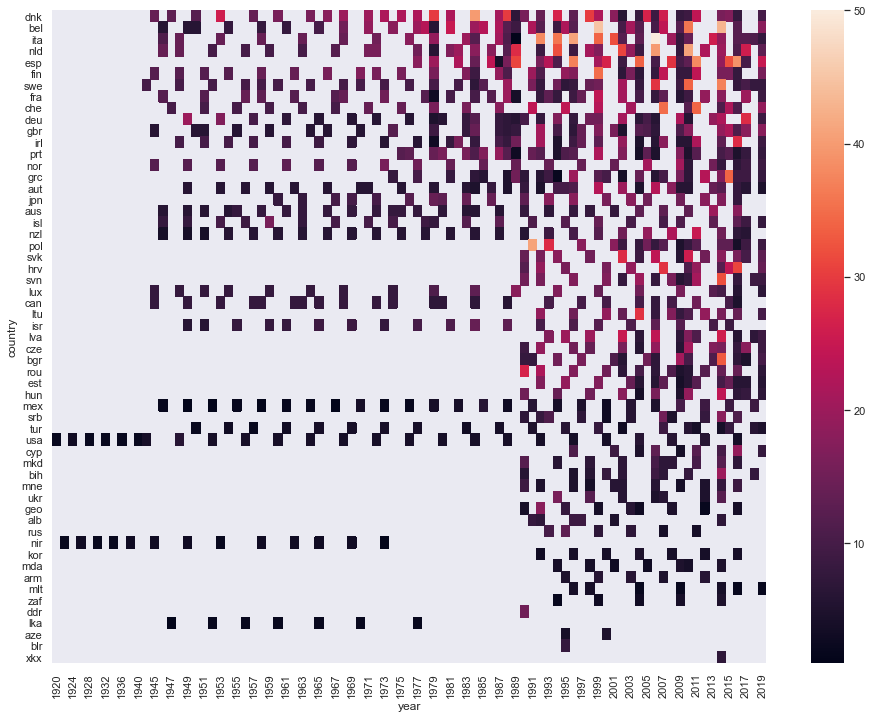

In [78]:
plt.figure(figsize=(16,12))
sns.heatmap(df_2d);